Imports & Relative Path Setup

Verify Data

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

# ================= CONFIGURATION =================
# Update this to point to your extracted folder
DATASET_ROOT = Path("Kvasir-SEG") 
IMAGE_DIR = DATASET_ROOT / "images"
MASK_DIR = DATASET_ROOT / "masks"
# =================================================

def verify_dataset():
    # 1. Check if directories exist
    if not IMAGE_DIR.exists() or not MASK_DIR.exists():
        print(f"❌ Error: Could not find directories.")
        print(f"   Looking for: {IMAGE_DIR}")
        print(f"   Looking for: {MASK_DIR}")
        return

    # 2. Get list of files
    image_files = sorted([f.name for f in IMAGE_DIR.iterdir() if f.suffix in ['.jpg', '.png', '.jpeg']])
    mask_files = sorted([f.name for f in MASK_DIR.iterdir() if f.suffix in ['.jpg', '.png', '.jpeg']])

    print(f"📂 Found {len(image_files)} images and {len(mask_files)} masks.")

    if len(image_files) == 0:
        print("❌ Error: No images found. Check your path.")
        return

    # 3. Verify pairs and dimensions
    mismatches = []
    dimension_errors = []
    
    print("🔍 Verifying alignment...")
    
    for img_name in image_files:
        # Construct mask path (Assuming filenames are identical)
        # If your masks have a suffix like '_mask', modify this line.
        mask_name = img_name 
        img_path = IMAGE_DIR / img_name
        mask_path = MASK_DIR / mask_name

        # A. Check if mask exists
        if not mask_path.exists():
            mismatches.append(img_name)
            continue

        # B. Check dimensions (We only check a few random ones for speed, or all if dataset is small)
        # Kvasir-SEG is small (1000 imgs), so we can check all quickly.
        img = cv2.imread(str(img_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"   ⚠️ Warning: Could not read {img_name}")
            continue

        if img.shape[:2] != mask.shape[:2]:
            dimension_errors.append(f"{img_name} (Img: {img.shape[:2]} vs Mask: {mask.shape[:2]})")

    # 4. Report Results
    if not mismatches and not dimension_errors:
        print("\n✅ SUCCESS: All images have matching masks with correct dimensions.")
        
        # 5. Visualize a random sample
        visualize_sample(image_files)
    else:
        print(f"\n❌ ISSUES FOUND:")
        if mismatches:
            print(f"   - {len(mismatches)} images missing masks (e.g., {mismatches[:3]})")
        if dimension_errors:
            print(f"   - {len(dimension_errors)} dimension mismatches (e.g., {dimension_errors[:3]})")

def visualize_sample(image_files):
    """Show a random image and mask side-by-side"""
    random_img = random.choice(image_files)
    img_path = str(IMAGE_DIR / random_img)
    mask_path = str(MASK_DIR / random_img)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Image: {random_img}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, cmap='jet', alpha=0.5) # Overlay mask with transparency
    plt.title("Overlay Check")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    verify_dataset()

Split Data

In [ ]:
import os
import shutil
import random
from pathlib import Path
from tqdm import tqdm  # Optional: for progress bar, install via 'pip install tqdm' if needed

# ================= CONFIGURATION =================
# Input: Your raw downloaded folder
SOURCE_ROOT = Path("Kvasir-SEG") 
SOURCE_IMGS = SOURCE_ROOT / "images"
SOURCE_MASKS = SOURCE_ROOT / "masks"

# Output: Where the clean dataset will go
DEST_ROOT = Path("data")

# Split Ratios (Must sum to 1.0)
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
SEED = 42  # The answer to life, the universe, and reproducible splits
# =================================================

def create_split():
    # 1. Setup Determinism
    random.seed(SEED)
    
    # 2. Get list of file IDs (filenames without path)
    # We assume verify_data.py already confirmed they match.
    all_files = sorted([f.name for f in SOURCE_IMGS.iterdir() if f.name != ".DS_Store"])
    random.shuffle(all_files) # Shuffle them randomly
    
    total_files = len(all_files)
    print(f"📦 Processing {total_files} file pairs...")

    # 3. Calculate Split Indices
    train_end = int(total_files * TRAIN_RATIO)
    val_end = train_end + int(total_files * VAL_RATIO)

    # Slice the list
    splits = {
        "train": all_files[:train_end],
        "val":   all_files[train_end:val_end],
        "test":  all_files[val_end:]
    }

    print(f"   - Train: {len(splits['train'])}")
    print(f"   - Val:   {len(splits['val'])}")
    print(f"   - Test:  {len(splits['test'])}")

    # 4. Create Directories and Copy Files
    if DEST_ROOT.exists():
        print(f"⚠️  Warning: '{DEST_ROOT}' already exists. Merging/Overwriting...")
    
    for split_name, files in splits.items():
        # Create structure: data/train/images and data/train/masks
        split_img_dir = DEST_ROOT / split_name / "images"
        split_mask_dir = DEST_ROOT / split_name / "masks"
        
        split_img_dir.mkdir(parents=True, exist_ok=True)
        split_mask_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"🚀 Copying {split_name} data...")
        
        for filename in files:
            # Source Paths
            src_img = SOURCE_IMGS / filename
            src_mask = SOURCE_MASKS / filename 
            
            # Destination Paths
            dst_img = split_img_dir / filename
            dst_mask = split_mask_dir / filename
            
            # Copy Metadata + Content
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_mask, dst_mask)

    print(f"\n✅ SUCCESS: Dataset split created at: {DEST_ROOT.absolute()}")
    print("   Structure:")
    print("   data/")
    print("     ├── train/ (images, masks)")
    print("     ├── val/   (images, masks)")
    print("     └── test/  (images, masks)")

if __name__ == "__main__":
    if not SOURCE_ROOT.exists():
        print(f"❌ Error: Cannot find {SOURCE_ROOT}. Are you in the right directory?")
    else:
        create_split()

Data Set Creation

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%pip install torch torchvision
from torch.utils.data import Dataset, DataLoader # Assuming PyTorch usage
from PIL import Image

# --- RELATIVE PATH SETUP ---
# Get the directory where this notebook is running
BASE_DIR = Path.cwd()

# Define the path to your data folder relative to this notebook
DATA_DIR = BASE_DIR / "data"

print(f"✅ Project Root: {BASE_DIR}")
print(f"📂 Data Directory: {DATA_DIR}")

# Check if it exists
if not DATA_DIR.exists():
    print("❌ Error: 'data' folder not found. Did you run the split script?")
else:
    print("Found 'data' folder. Ready to load.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 84.4 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 45.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [torchvision] [torchvision]
Note: you may need to restart the kernel to use updated packages.



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/3_10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/3_10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/3_10/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/3_10/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
 

✅ Project Root: /Users/noahmays-smith/Desktop/NYU/FAMS
📂 Data Directory: /Users/noahmays-smith/Desktop/NYU/FAMS/data
Found 'data' folder. Ready to load.


Dataset Class

In [3]:
class KvasirDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        """
        Args:
            root_dir (Path or str): Path to the 'data' folder.
            split (str): 'train', 'val', or 'test'.
            transform (callable, optional): Optional transform to be applied.
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        
        # Define paths for this split
        self.img_dir = self.root_dir / split / "images"
        self.mask_dir = self.root_dir / split / "masks"
        
        # Get list of images (sorting ensures alignment)
        self.images = sorted([f.name for f in self.img_dir.iterdir() if f.name != ".DS_Store"])
        
        # Verify valid split
        if not self.img_dir.exists():
            raise FileNotFoundError(f"Split '{split}' does not exist in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # 1. Load Image
        img_path = self.img_dir / img_name
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # OpenCV loads BGR, convert to RGB
        
        # 2. Load Mask
        mask_path = self.mask_dir / img_name
        # Load as grayscale (0-255)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        # 3. Binarize Mask (Critical for Segmentation)
        # Kvasir masks are already good, but this safeguards against anti-aliasing artifacts
        # Any pixel > 127 becomes 1 (polyp), else 0 (background)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
        
        if self.transform:
            # Note: In a real pipeline, you'd apply augmentations here.
            # You must ensure geometric transforms (flip, rotate) apply to BOTH img and mask.
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

Visualization

Dataset Size: 800 samples


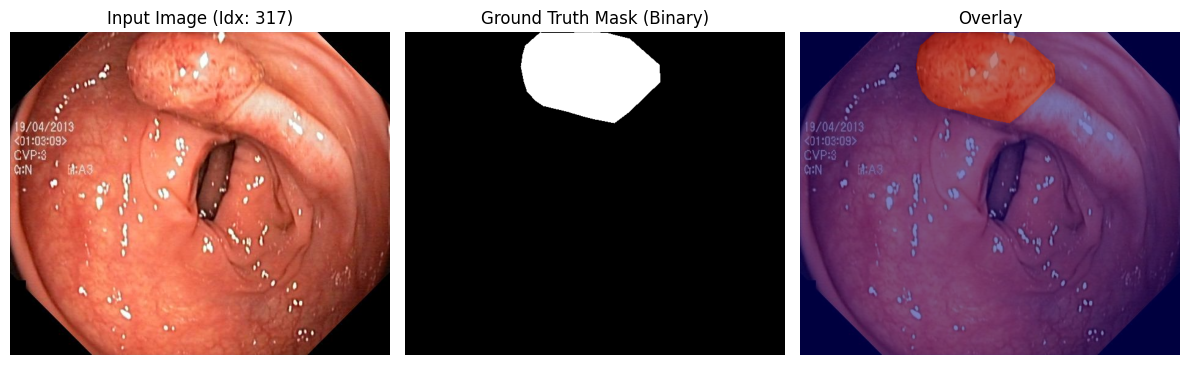

In [4]:
# Instantiate the train dataset
train_dataset = KvasirDataset(DATA_DIR, split="train")

print(f"Dataset Size: {len(train_dataset)} samples")

# Helper function to visualize
def visualize_sample(dataset, idx):
    image, mask = dataset[idx]
    
    plt.figure(figsize=(12, 6))
    
    # Plot Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Input Image (Idx: {idx})")
    plt.axis("off")
    
    # Plot Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask (Binary)")
    plt.axis("off")
    
    # Plot Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, cmap="jet", alpha=0.5) # Overlay with transparency
    plt.title("Overlay")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize a few random samples
import random
random_idx = random.randint(0, len(train_dataset)-1)
visualize_sample(train_dataset, random_idx)